In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import convolve,Gaussian2DKernel
from matplotlib import colors
from matplotlib import rcParams

#set the default plot parameter
plt_param={'font.family':'serif',
           'font.serif':'Times New Roman',
           'lines.linewidth':.8,
           'xtick.labelsize':12,
           'ytick.labelsize':12,
           'axes.labelsize':16,
           'xtick.direction':'in',
           'ytick.direction':'in',
           'font.style':'italic',
           'font.weight':'normal',
           'figure.figsize':[5,5],'xtick.minor.visible':True,
           'ytick.minor.visible':True,
           'xtick.major.size':4,
           'ytick.major.size':4,
           'xtick.minor.size':2,
           'ytick.minor.size':2,
           'xtick.major.width':.8,
           'ytick.major.width':.8,
           'xtick.top':True,
           'ytick.right':True,
           'axes.spines.bottom':True,
           'axes.spines.top':True,
           'axes.spines.left':True,
           'axes.spines.right':True,
           'xtick.bottom':True,
           'xtick.labelbottom':True,
           'ytick.left':True,
           'ytick.labelleft':True}
rcParams.update(plt_param)

In [4]:
def pix2world(shape,delta,origin_pix,origin_world):
    '''
    convert pixel coordinate to
    ra,dec, origin_pix and origin_world
    is the coordinate of origin in 
    different frame. They are both 1-d
    array with two elements
    return two 1-d arrays of ra and 
    dec respectively
    '''
    
    x,y=np.arange(shape[0]),np.arange(shape[1])
    X,Y=np.meshgrid(x,y)
    ra_map=(X-origin_pix[0])*delta[0]+origin_world[0]
    dec_map=(Y-origin_pix[1])*delta[1]+origin_world[1]
    
    return ra_map.mean(axis=0), dec_map.mean(axis=1)
    
def smooth(img, xsigma,ysigma,xsize,ysize):
    '''
    smooth the image
    '''
    #create the smooth kernel
    kernel=Gaussian2DKernel(x_stddev=xsigma,y_stddev=ysigma,
                            x_size=xsize,y_size=ysize)
    img_smoothed=convolve(img,kernel)
    
    return img_smoothed

read SNR map of Ly$\rm \alpha$ emission and the contour on H$\rm \alpha$ emission

In [5]:
# read the smoothed ratio map
dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/results/'
ratio_fits=fits.open(dic+'mammoth_smo_ratio2.fits')
ratio_map=ratio_fits[0].data

In [6]:
img=ratio_map[90:-80,50:-50].copy()
img[img>2.5]=0

In [7]:
# calculate ra and dec map
delta=[6.864583279e-05,7.077716112e-05]
origin_pix=[142,145]
origin_world=[220.3520935,40.05268459]
ra,dec=pix2world(ratio_map.shape,delta,origin_pix,origin_world)
delta_ra=(ra-origin_world[0])*u.deg.to(u.arcsecond)
delta_dec=(dec-origin_world[1])*u.deg.to(u.arcsecond)

In [8]:
sources=np.array([[40.052625, 220.3519792], [40.05221366, 220.3519858],
                  [40.05297755, 220.3520401], [40.05222735, 220.3493004],
                  [40.0542892, 220.3529902], [40.05224151, 220.3531833],
                  [40.0535024, 220.349928],[40.05106072, 220.3497904]])*u.deg
delta_sources=(sources-origin_world[::-1]*u.deg).to(u.arcsec).value

In [9]:
# cut image
ratio_map=ratio_map[50:-50,80:-80]
delta_ra,delta_dec=delta_ra[80:-80],delta_dec[50:-50]

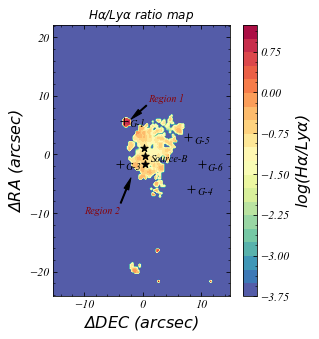

In [52]:
# plot the ratio map
fig_dic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/draft_code/paper/ApJtemplate/figs/'
ratio_map+=1e-5
ra_map,dec_map=np.meshgrid(delta_ra,delta_dec)
fig,ax=plt.subplots(1,1)
img=ax.contourf(ra_map.T,dec_map.T,np.log10(ratio_map.T),
                cmap='Spectral_r',levels=20)
ax.scatter(-delta_sources[3:,1],delta_sources[3:,0],
           marker='+',color='black',s=60.)
ax.scatter(-delta_sources[:3,1],delta_sources[:3,0],
           marker='*',color='black',s=60.)
ax.text(-delta_sources[0,1]+1,delta_sources[0,0]-1,
        'Source-B',fontsize=10,weight='heavy')
ax.annotate(r'Region 1', xy=(-2, 6),color='darkred',
            xytext=(1,9),xycoords='data',
            arrowprops=dict(facecolor='black', 
                            shrink=1e-5,width=1,headwidth=5))
ax.annotate(r'Region 2', xy=(-2, -4),color='darkred',
            xytext=(-10,-10),xycoords='data',
            arrowprops=dict(facecolor='black', 
                            shrink=1e-5,width=1,headwidth=5))
label=['G-6','G-1','G-3','G-5','G-4']
for i in range(3,8):
    ax.text(-delta_sources[i,1]+1,delta_sources[i,0]-1,
        label[i-3],fontsize=10,weight='heavy')
ax.set_xlabel(r'$\rm \Delta DEC \ (arcsec)$')
ax.set_ylabel(r'$\rm \Delta RA \ (arcsec)$')
ax.set_title(r'$\rm H\alpha/Ly\alpha \ ratio  \ map$')
ax.set_aspect('equal')
cbar=plt.colorbar(img)
cbar.ax.set_ylabel(r'$\rm log(H\alpha/Ly\alpha)$')
plt.savefig(fig_dic+'H_alpha_ly_alpha_ratio.png',dpi=300)
# plt.show()